### Importing Modules

In [3]:
import sys
from pathlib import Path

project_root = Path("/home/vansh/projects/project-nova").resolve()

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))


import numpy as np
import pandas as pd
from src.data import save_csv
from src.config import DATA_DIR, TARGET_COLUMN
from src.utils import set_seed

### 1. Ensure reproducibility

In [3]:
set_seed(42)

### 2. Number of rows


In [4]:
n_rows = 10_000


### 3. Generate basic features


In [5]:
monthly_earnings = np.random.normal(30000, 8000, n_rows)        # avg 30k ± 8k
trips_per_week = np.random.poisson(30, n_rows)                  # avg 30 trips/week
avg_rating = np.clip(np.random.normal(4.6, 0.3, n_rows), 1, 5)  # 1–5 scale
cancellation_rate = np.clip(np.random.beta(1, 10, n_rows), 0, 1) # 0–1 proportion
active_days_per_month = np.random.randint(5, 31, n_rows)        # 5–30 days

### 4. Create ground-truth Nova Score


In [6]:
#    We'll weight the features: earnings (40%), trips (20%), rating (20%), cancellations (-10%), active_days (10%)
#    Then add some noise to simulate variability.
score_raw = (
    (monthly_earnings / 50000) * 40 +         # normalized earnings to 0–40 points
    (trips_per_week / 60) * 20 +              # normalized trips to 0–20 points
    (avg_rating / 5) * 20 +                   # rating to 0–20 points
    ((1 - cancellation_rate) * 10) +          # fewer cancellations = higher score
    (active_days_per_month / 30) * 10         # active days to 0–10 points
)

# Add Gaussian noise (±5 points)
noise = np.random.normal(0, 5, n_rows)
nova_score = np.clip(score_raw + noise, 0, 100)  # keep between 0 and 100

### 5. Build DataFrame


In [7]:
df = pd.DataFrame({
    "partner_id": [f"P{i+1:05d}" for i in range(n_rows)],
    "monthly_earnings": monthly_earnings.round(2),
    "trips_per_week": trips_per_week,
    "avg_rating": avg_rating.round(2),
    "cancellation_rate": cancellation_rate.round(3),
    "active_days_per_month": active_days_per_month,
    TARGET_COLUMN: nova_score.round(2),
})

### 6. Save to CSV

In [8]:
DATA_DIR.mkdir(parents=True, exist_ok=True)
csv_path = DATA_DIR / "synthetic_basic_10k.csv"
save_csv(df, csv_path)


### 7. Quick check


In [9]:
print(f"Saved dataset to: {csv_path}")
print(f"Shape: {df.shape}")
df.head()

Saved dataset to: /home/vansh/projects/project-nova/data/synthetic_basic_10k.csv
Shape: (10000, 7)


,partner_id,monthly_earnings,trips_per_week,avg_rating,cancellation_rate,active_days_per_month,Nova_Score
0,P00001,33973.71,27,4.40,0.050,23,71.01
1,P00002,28893.89,20,4.72,0.052,16,63.45
2,P00003,35181.51,31,4.66,0.069,23,81.22
3,P00004,42184.24,27,4.69,0.022,15,73.58
4,P00005,28126.77,26,4.71,0.019,5,66.21


# --- BASIC EDA ---



### 0. Importing Modules

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Load the saved dataset


In [6]:
import pandas as pd
df = pd.read_csv('/home/vansh/projects/project-nova/data/synthetic_basic_10k.csv')

### 2. Quick info


In [7]:
print("Data shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

Data shape: (10000, 7)

Data types:
 partner_id                object
monthly_earnings         float64
trips_per_week             int64
avg_rating               float64
cancellation_rate        float64
active_days_per_month      int64
Nova_Score               float64
dtype: object

Missing values:
 partner_id               0
monthly_earnings         0
trips_per_week           0
avg_rating               0
cancellation_rate        0
active_days_per_month    0
Nova_Score               0
dtype: int64


### 3. Summary statistics


In [8]:
display(df.describe())


,monthly_earnings,trips_per_week,avg_rating,cancellation_rate,active_days_per_month,Nova_Score
count,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,29982.912138,29.92600,4.583866,0.090316,17.443000,67.240225
std,8027.698994,5.39791,0.278673,0.081605,7.480946,8.857600
min,-1379.200000,11.00000,3.260000,0.000000,5.000000,34.960000
25%,24619.280000,26.00000,4.390000,0.029000,11.000000,61.420000
50%,29979.240000,30.00000,4.600000,0.067000,17.000000,67.275000
75%,35368.645000,33.00000,4.800000,0.129000,24.000000,73.230000
max,61409.900000,51.00000,5.000000,0.640000,30.000000,98.820000


### 4. Histograms for numeric features


<Figure size 1500x1000 with 0 Axes>

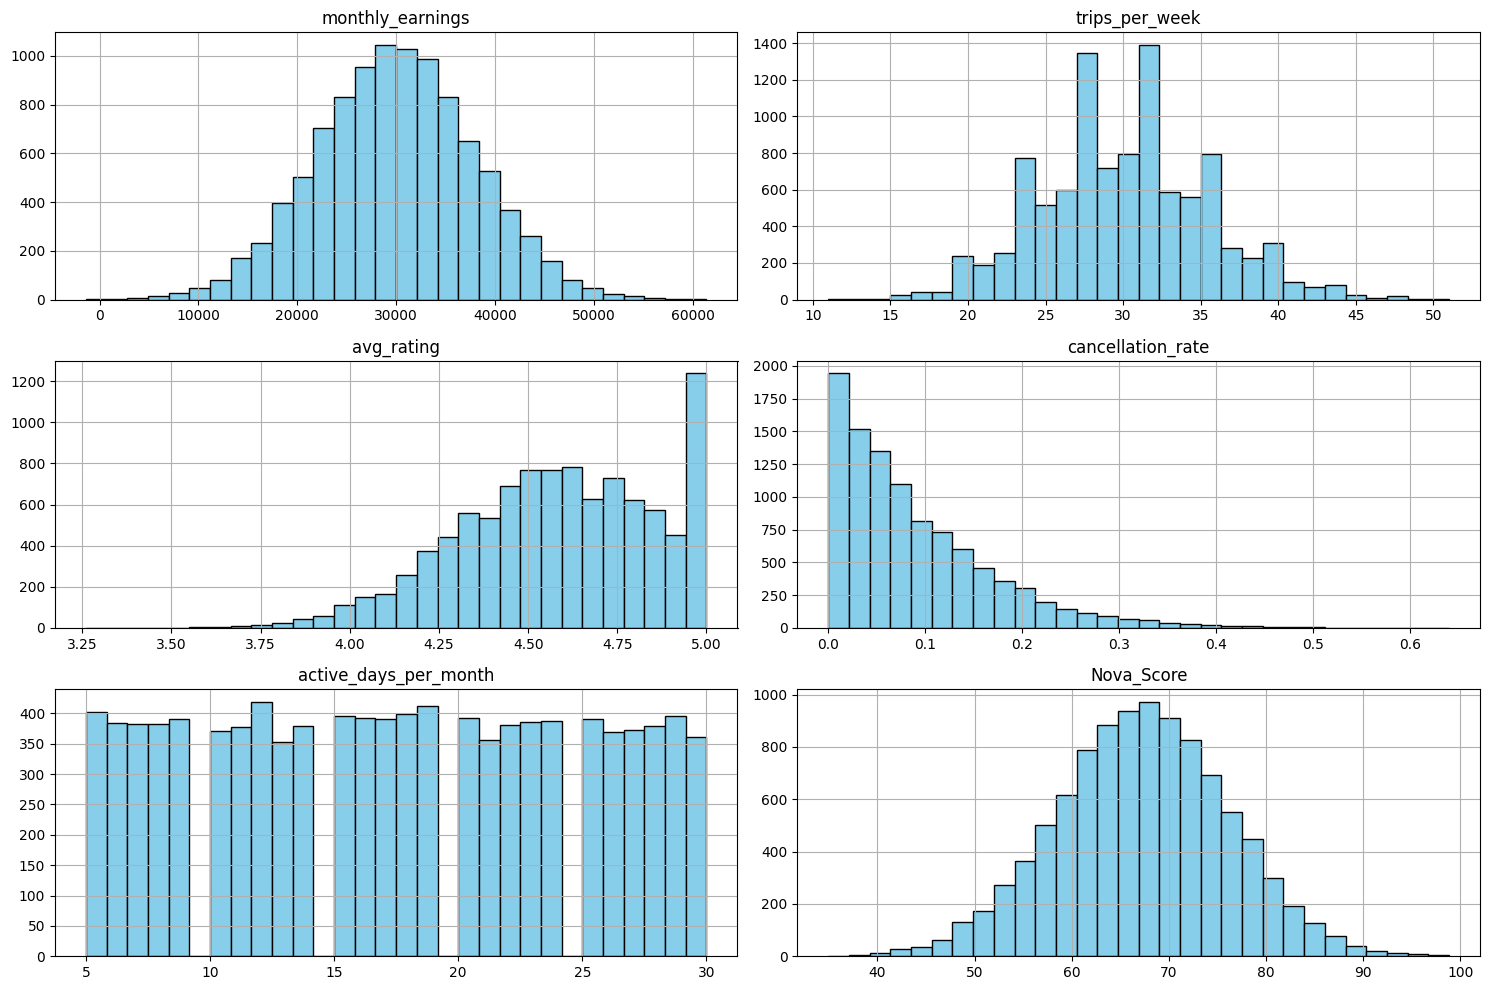

In [9]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

plt.figure(figsize=(15, 10))
df[numeric_cols].hist(bins=30, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

### 5. Correlation heatmap


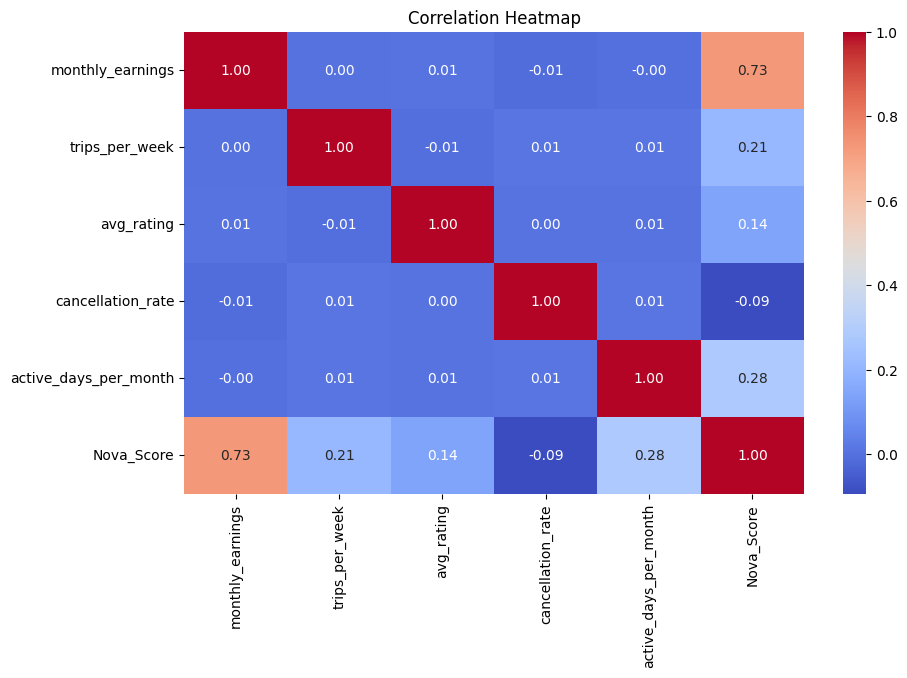

In [10]:
plt.figure(figsize=(10, 6))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### 6. Scatter plots vs Nova_Score


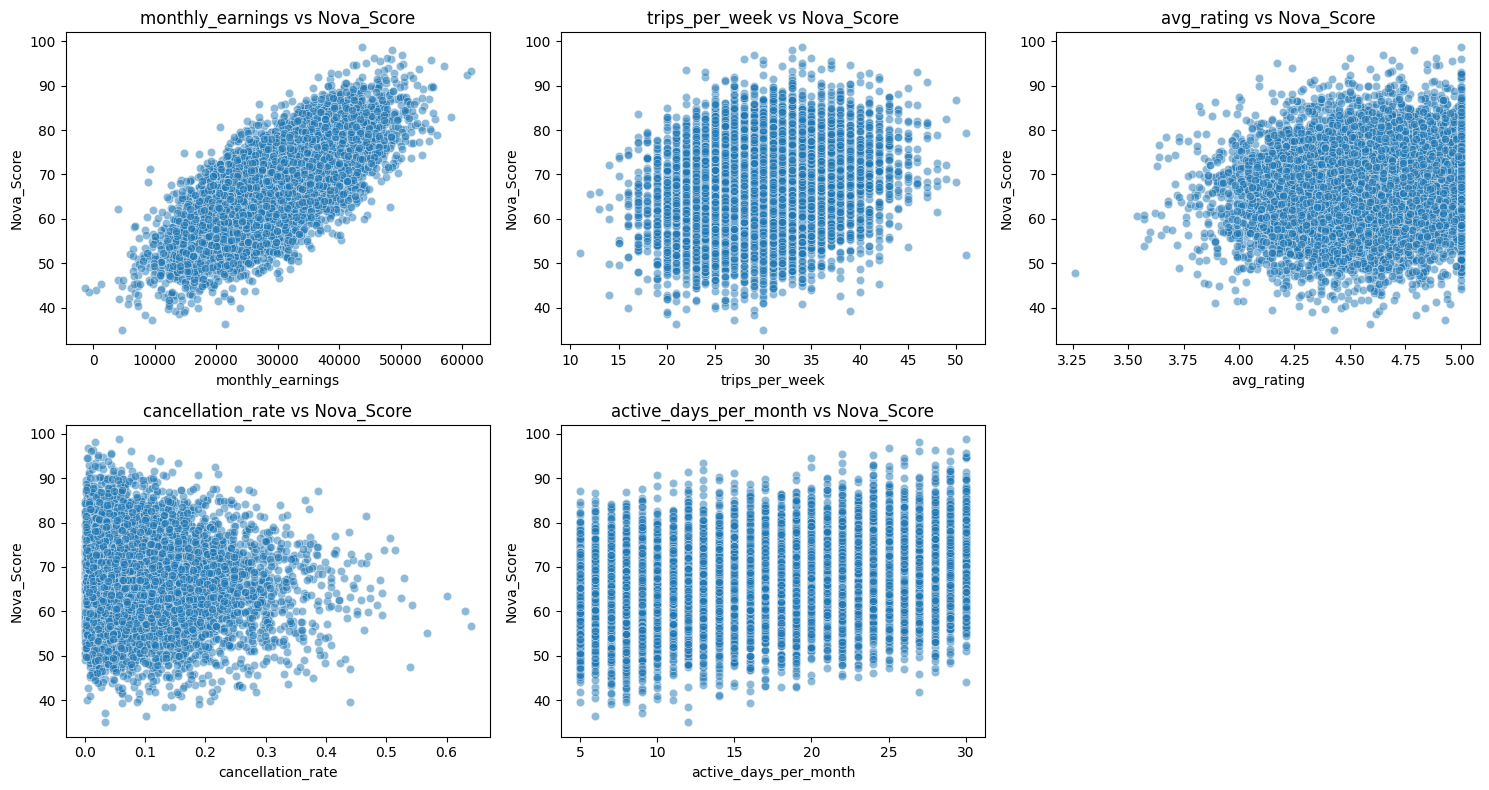

In [11]:
features_to_plot = ["monthly_earnings", "trips_per_week", "avg_rating", "cancellation_rate", "active_days_per_month"]
plt.figure(figsize=(15, 8))
for i, col in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=df, x=col, y="Nova_Score", alpha=0.5)
    plt.title(f"{col} vs Nova_Score")
plt.tight_layout()
plt.show()